In [3]:
import os 

from os import listdir
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from datetime import datetime

import IPython
import soundfile as sf
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score


import collections
import contextlib
import sys
import wave
import json
import pickle
import random
import torchaudio

%matplotlib inline
import matplotlib.pyplot as plt
import librosa

base_dir = "../dataset/"
test_file_path = os.path.join(base_dir, "testing_list.txt")
validation_file_path = os.path.join(base_dir, "validation_list.txt")
noise_path = os.path.join(base_dir, "_background_noise_/")

In [4]:
all_samples = []
labels_set = ['bed','bird','cat','dog','down','eight','five','four','go','happy','house',
              'left','marvin','nine','no','off','on','one','right','seven','sheila','six',
              'stop','three','tree','two','up','wow','yes','zero'
             ]

for word in listdir(base_dir):
    if os.path.isdir(os.path.join(base_dir, word)) and word in labels_set:
        for path in listdir(os.path.join(base_dir, word)):
            all_samples.append(os.path.join(word, path))

with open(test_file_path) as file:
    list_samples = file.read()
test_samples = list_samples.split('\n')[:-1]

with open(validation_file_path) as file:
    list_samples = file.read()
validation_samples = list_samples.split('\n')[:-1]

train_samples = list(set(all_samples) - set(validation_samples) - set(test_samples))
labels_set = ['down','go','left','no','off','on','right','stop','up','yes']

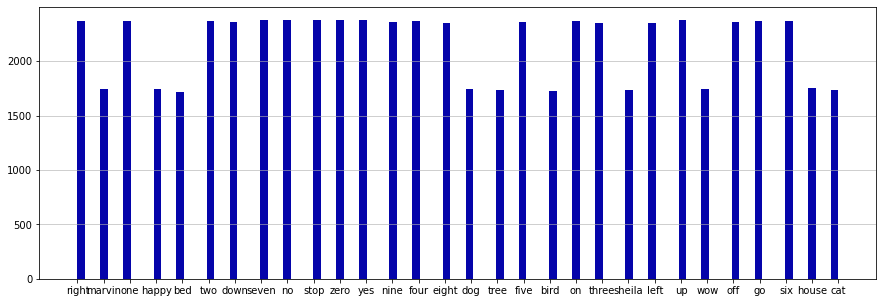

In [15]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

f, ax1 = plt.subplots(1, 1, sharey=True, figsize=(15,5))
ax1.hist(x=list(map(lambda x: x[:x.find('/')], all_samples)), bins=100, color='#0504aa')
ax1.grid(axis='y', alpha=0.75)

In [5]:
class SpeechDataset(data.Dataset):
    
#     LABEL_UNKNOWN = "__unknown__"
    def __init__(self, data, set_type, noise_path, labels_set, base_path, unknown_prob=0.1, silence_prob=0.1, noise_prob=0.8, timeshift_ms=100, input_length=16000, n_mels=40, n_mfcc=40, hop_ms=10):
        super().__init__()
        LABEL_SILENCE = "__silence__"
        LABEL_UNKNOWN = "__unknown__"
        self.base_path = base_path
        self.noise_path = noise_path
        self.audio_files = data
        self.set_type = set_type
        labels = list(map(lambda x: x[:x.find('/')], data))
        self.label2ind = {word: i + 2 for i, word in enumerate(labels_set)}
        self.label2ind.update({LABEL_SILENCE: 0, LABEL_UNKNOWN:1})
        self.audio_labels = list(map(lambda x: self.label2ind.get(x, 1), labels))
        self.n_mfcc = n_mfcc
        
        bg_noise_files = list(filter(lambda x: x.endswith("wav"), listdir(noise_path)))
        self.bg_noise_audio = [sf.read(os.path.join(noise_path, file))[0] for file in bg_noise_files]
        self.unknown_prob = unknown_prob
        self.silence_prob = silence_prob
        self.noise_prob = noise_prob
        self.input_length = input_length
        self.timeshift_ms = timeshift_ms
#         self._audio_cache = SimpleCache(config["cache_size"]) # todo
#         self._file_cache = SimpleCache(config["cache_size"])
        self._file_cache = {}
        self._audio_cache = {}
        n_unk = len(list(filter(lambda x: x == 1, self.audio_labels)))
        self.n_silence = int(self.silence_prob * (len(self.audio_labels) - n_unk))
        
        self.augment = Compose([
            TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
            PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
            Shift(min_fraction=-0.1, max_fraction=0.1, p=0.5, rollover=False),
        ])
        
        self.audio_transforms = nn.Sequential(
            torchaudio.transforms.MFCC(sample_rate=16000, n_mfcc=n_mfcc, melkwargs={'hop_length': 16 * hop_ms,
                                                                                "center": True, 'n_mels': n_mels}),
            torchaudio.transforms.SlidingWindowCmn(cmn_window=600, norm_vars=True, center=True)
        )
        self.train_audio_transforms = nn.Sequential(
        #     torchaudio.transforms.SlidingWindowCmn(cmn_window=600, norm_vars=True, center=True),
            torchaudio.transforms.FrequencyMasking(freq_mask_param=3),
            torchaudio.transforms.TimeMasking(time_mask_param=10)
        )
        
    def load_audio(self, example, silence=False):
        if silence:
            example = "__silence__"
        if random.random() < 0.7 or not self.set_type == 'train':
            try:
                return self._audio_cache[example]
            except KeyError:
                pass
        in_len = self.input_length
        if self.bg_noise_audio:
            bg_noise = random.choice(self.bg_noise_audio)
            a = random.randint(0, len(bg_noise) - in_len - 1)
            bg_noise = bg_noise[a:a + in_len]
        else:
            bg_noise = np.zeros(in_len)

        if silence:
            audio = np.zeros(in_len, dtype=np.float32)
        else:
            file_data = self._file_cache.get(example)
            audio = sf.read(os.path.join(self.base_path, example))[0] if file_data is None else file_data
            audio = audio.astype(np.float32)
            self._file_cache[example] = audio
        audio = np.pad(audio, (0, max(0, in_len - len(audio))), "constant")
        if self.set_type == 'train':
            audio = self.augment(samples=audio, sample_rate=16000)

        if random.random() < self.noise_prob or silence:
            if silence:
                a = random.random()
            else:
                a = random.random() * 0.1
            audio = np.clip(a * bg_noise + audio, -1, 1)
        
        torch_audio = torch.from_numpy(audio).float()
        transform_audio = self.audio_transforms(torch_audio).reshape(-1, self.n_mfcc)
        if self.set_type == 'train':
            transform_audio = self.train_audio_transforms(transform_audio)
        self._audio_cache[example] = transform_audio
        return transform_audio

    def __getitem__(self, index):
        if index >= len(self.audio_labels):
            return self.load_audio(None, silence=True), torch.tensor(0)
        return self.load_audio(self.audio_files[index]), torch.tensor(self.audio_labels[index])

    def __len__(self):
        return len(self.audio_labels) + self.n_silence
    
class SpeechResModel(nn.Module):
    def __init__(self, n_labels, n_feature_maps=45, n_layers=26, dilation=False, res_pool=2):
        super().__init__()
        self.n_labels = n_labels
        self.n_maps = n_feature_maps
        self.conv0 = nn.Conv2d(1, self.n_maps, (3, 3), padding=(1, 1), bias=False)
        self.avg_pool = res_pool
        if res_pool:
            self.pool = nn.AvgPool2d(res_pool)

        self.n_layers = n_layers
        if dilation:
            self.convs = [nn.Conv2d(self.n_maps, self.n_maps, (3, 3), padding=int(2**(i // 3)), dilation=int(2**(i // 3)),
                bias=False) for i in range(n_layers)]
        else:
            self.convs = [nn.Conv2d(self.n_maps, self.n_maps, (3, 3), padding=1, dilation=1,
                bias=False) for _ in range(n_layers)]
        for i, conv in enumerate(self.convs):
            self.add_module("bn{}".format(i + 1), nn.BatchNorm2d(self.n_maps, affine=False))
            self.add_module("conv{}".format(i + 1), conv)
        self.output = nn.Linear(self.n_maps, self.n_labels)

    def forward(self, x):
        x = x.unsqueeze(1)
        for i in range(self.n_layers + 1):
            y = F.relu(getattr(self, "conv{}".format(i))(x))
            if i == 0:
                if self.avg_pool:
                    y = self.pool(y)
                old_x = y
            if i > 0 and i % 2 == 0:
                x = y + old_x
                old_x = x
            else:
                x = y
            if i > 0:
                x = getattr(self, "bn{}".format(i))(x)
        x = x.view(x.size(0), x.size(1), -1) # shape: (batch, feats, o3)
        x = torch.mean(x, 2)
        return self.output(x)

def testModel(model, test_samples, noise_path, labels_set, base_dir, max_samples=10000, batch_size=1, device='cpu', n_mels=40):
    
    model.to(device)
    
    test_dataset = SpeechDataset(test_samples, 'test', noise_path, labels_set, base_dir, n_mels=n_mels)
    
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False)

    print('DATASET SIZE: {}'.format(len(test_dataset)))
    
    model.eval()
    preds = []
    test_y = []
    for x, y in tqdm(test_loader):
        
        with torch.no_grad():
            test_y.append(y.numpy())
            output = model(x.float().to(device))
            pred = output.cpu().detach().numpy()
            preds.extend(pred)
    del test_dataset
    return test_y, preds

In [6]:
model = SpeechResModel(n_labels=len(labels_set)+2, dilation=True).float()
model.load_state_dict(torch.load('../models/model_v4.pt'))
model.eval()

SpeechResModel(
  (conv0): Conv2d(1, 45, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (bn1): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv1): Conv2d(45, 45, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv2): Conv2d(45, 45, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv3): Conv2d(45, 45, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv4): Conv2d(45, 45, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
  (bn5): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (conv5): Conv2d

In [7]:
test_y, preds = testModel(model, test_samples, noise_path, labels_set, base_dir, device='cuda', batch_size=32, n_mels=64)
test_y = np.hstack(test_y)
preds = torch.softmax(torch.from_numpy(np.vstack(preds)), dim=1).numpy()

  1%|          | 2/222 [00:00<00:20, 10.92it/s]

DATASET SIZE: 7091


100%|██████████| 222/222 [00:20<00:00, 10.63it/s]


In [9]:
test_y

array([1, 1, 1, ..., 0, 0, 0])

In [8]:
accuracy_score(test_y, preds.argmax(1))

0.9170779861796644

In [24]:
print(classification_report(test_y, preds.argmax(1).astype(int)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       256
           1       0.92      0.97      0.95      4268
           2       0.86      0.77      0.81       253
           3       0.84      0.73      0.78       251
           4       0.94      0.82      0.88       267
           5       0.81      0.73      0.77       252
           6       0.92      0.81      0.86       262
           7       0.91      0.78      0.84       246
           8       0.90      0.82      0.86       259
           9       0.90      0.87      0.88       249
          10       0.87      0.87      0.87       272
          11       0.93      0.91      0.92       256

    accuracy                           0.91      7091
   macro avg       0.90      0.84      0.87      7091
weighted avg       0.91      0.91      0.91      7091



In [85]:
a = []
for i, vec in enumerate(preds):
    j = test_y[i]
    a.append(vec[j].tolist())
far = []
threshold = []

grid = np.arange(0, 1.01, 0.01)
for i in grid:
    num = 0

    for x in a:
        if x > i:
            num += 1

    far.append(num)
    threshold.append(i)

far = np.array(far)
far = far / far.max()

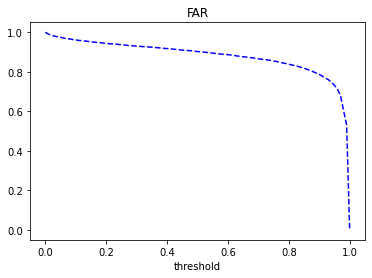

In [86]:
plt.plot(grid, far,'--b')
plt.xlabel('threshold')
plt.title('FAR')
plt.show()

In [97]:
b = []
for i, vec in enumerate(torch.from_numpy(preds)):
    j = test_y[i]
    if (j == vec.argmax()).tolist():
        b.append(vec[j].tolist())

frr = []
grid = np.arange(0, 1.01, 0.01)
for i in grid:
    num = 0

    for x in b:
        if x < i:
            num += 1
    frr.append(num)

frr = np.array(frr)
frr = frr / 7091

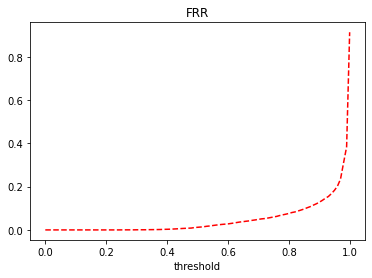

In [98]:
plt.plot(grid, frr,'--r')
plt.xlabel('threshold')
plt.title('FRR')
plt.show()

In [106]:
for i, thr in enumerate(grid):
    if np.abs(far[i] - frr[i]) < 0.09:
        eer = far[i]
        eer_thr = thr
        print(grid[frr < 0.1].max(), grid[far < 0.1].min(), eer_thr, eer * 100)

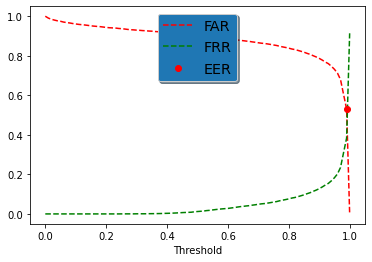

In [111]:
fig, ax = plt.subplots()

ax.plot(grid, far, 'r--', label='FAR')
ax.plot(grid, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
plt.plot(eer_thr, eer,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()